Q1) Dataset contains Monthly and Daily prices of Natural gas, starting from January 1997 to current year. Prices are in nominal dollars. The task is to predict the price of natural gas using RNN model for the dataset
https://datahub.io/core/natural-gas#resource-daily 
https://www.kaggle.com/datasets/joebeachcapital/natural-gas-prices

Given the price of last ten 10 days, corresponds to sequence_length, the RNN model must predict the price for the 11th day

         Date  Price
0  1997-01-07   3.82
1  1997-01-08   3.80
2  1997-01-09   3.61
3  1997-01-10   3.92
4  1997-01-13   4.00
[[0.1589214 ]
 [0.15777395]
 [0.14687321]
 ...
 [0.08089501]
 [0.07171543]
 [0.06712565]]


/home/mustafa/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 0.01779
Epoch 2, Loss: 0.01738
Epoch 3, Loss: 0.01731
Epoch 4, Loss: 0.01720
Epoch 5, Loss: 0.01730
Epoch 6, Loss: 0.01730
Epoch 7, Loss: 0.01724
Epoch 8, Loss: 0.01725
Epoch 9, Loss: 0.01733
Epoch 10, Loss: 0.01718


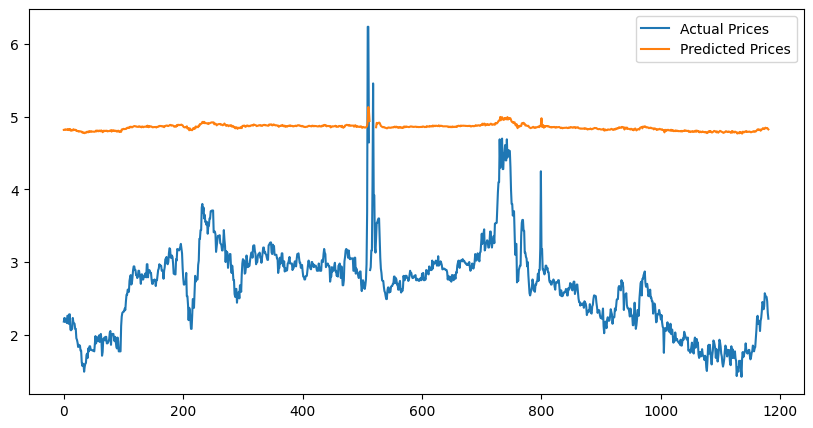

Predicted 11th Day Price: $4.82


In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


# Replace with your actual file path
file_path = "/home/mustafa/dllab/w8prac/q1/daily_csv.csv"

# Load the dataset
df = pd.read_csv(file_path)

# Display the first few rows
print(df.head())

# Convert date column to datetime format
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Use only price column
prices = df["Price"].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)
print(prices_scaled)
class NaturalGasDataset(Dataset):
    def __init__(self, data, seq_length=10):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.seq_length]
        y = self.data[idx + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Split data into train (80%) and test (20%)
train_size = int(0.8 * len(prices_scaled))
train_data, test_data = prices_scaled[:train_size], prices_scaled[train_size:]

train_dataset = NaturalGasDataset(train_data)
test_dataset = NaturalGasDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        return self.fc(out[:, -1, :])

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNModel().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch = X_batch.view(X_batch.shape[0], X_batch.shape[1], 1)  # Reshape for RNN

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.5f}")

model.eval()
predictions, actuals = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device).view(1, -1, 1)
        y_batch = y_batch.item()

        pred = model(X_batch).item()

        predictions.append(pred)
        actuals.append(y_batch)

# Convert predictions back to original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

plt.figure(figsize=(10, 5))
plt.plot(actuals, label="Actual Prices")
plt.plot(predictions, label="Predicted Prices")
plt.legend()
plt.show()

import torch
import numpy as np

# Select last 10 days from the dataset
last_10_days = prices_scaled[-10:].reshape(1, 10, 1)  # Reshape to (batch_size, seq_length, input_size)
last_10_days_tensor = torch.tensor(last_10_days, dtype=torch.float32).to(device)
model.eval()

# Predict the 11th day's price
with torch.no_grad():
    predicted_scaled = model(last_10_days_tensor).cpu().numpy()

# Convert back to original price scale
predicted_price = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))

print(f"Predicted 11th Day Price: ${predicted_price[0][0]:.2f}")


Epoch 0 Loss: 0.0003
Epoch 10 Loss: 0.0000
Epoch 20 Loss: 0.0001
Epoch 30 Loss: 0.0000
Epoch 40 Loss: 0.0000
Epoch 50 Loss: 0.0003
Epoch 60 Loss: 0.0001
Epoch 70 Loss: 0.0001
Epoch 80 Loss: 0.0005
Epoch 90 Loss: 0.0000


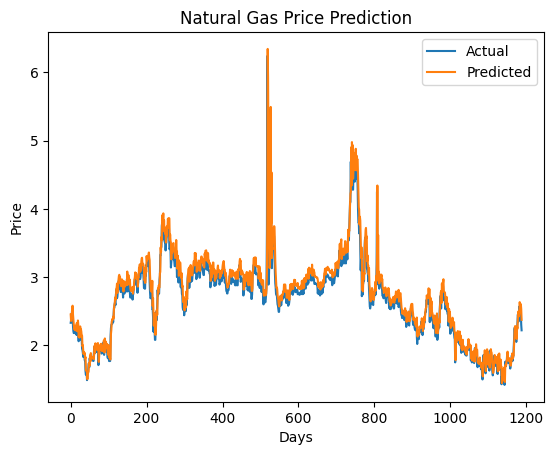

In [4]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load and normalize data
df = pd.read_csv("/home/mustafa/dllab/w8prac/q1/daily_csv.csv")
df = df.dropna()
prices = df['Price'].values.reshape(-1, 1)

scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

# Prepare sequences
sequence_length = 10
X, Y = [], []
for i in range(len(prices_scaled) - sequence_length):
    X.append(prices_scaled[i:i + sequence_length])
    Y.append(prices_scaled[i + sequence_length])

X = np.array(X)
Y = np.array(Y)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, shuffle=False)

# Custom dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self): return len(self.x)
    def __getitem__(self, idx): return self.x[idx], self.y[idx]

# Dataloaders
train_loader = DataLoader(TimeSeriesDataset(x_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(TimeSeriesDataset(x_test, y_test), batch_size=1)

# RNN model
class RNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

model = RNNModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(100):
    for xb, yb in train_loader:
        xb = xb.view(-1, sequence_length, 1)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} Loss: {loss.item():.4f}")

# Testing
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.view(-1, sequence_length, 1)
        pred = model(xb)
        predictions.append(pred.item())
        actuals.append(yb.item())

# Inverse scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

# Plot results
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title("Natural Gas Price Prediction")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()


In [5]:
# Take last 10 actual values from the full (normalized) dataset
last_10_days = torch.tensor(prices_scaled[-10:], dtype=torch.float32).view(1, 10, 1)

# Predict the 11th day price
model.eval()
with torch.no_grad():
    next_day_pred = model(last_10_days).item()

# Inverse transform to get the original price scale
next_day_price = scaler.inverse_transform([[next_day_pred]])
print(f"\n🧠 Predicted price for the 11th day: ${next_day_price[0][0]:.4f}")



🧠 Predicted price for the 11th day: $2.3135


Q2) The data provided at the link https://download.pytorch.org/tutorial/data.zip consists of
names stored in the format {language: [names ...]} i.e. each language contains a list of
names. Train a RNN on a few thousand surnames from 18 languages of origin, and
predict which language a name is from based on the spelling.

In [1]:
import os
import glob
import torch
import string
import random
import numpy as np

ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

def name_to_tensor(name):
    tensor = torch.zeros(len(name), 1, N_LETTERS)
    for i, letter in enumerate(name):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor

def read_names(filename):
    with open(filename, encoding='utf-8') as f:
        return [line.strip() for line in f.readlines()]

language_names = {}
for filepath in glob.glob("data/names/*.txt"):
    language = os.path.splitext(os.path.basename(filepath))[0]
    language_names[language] = read_names(filepath)

languages = list(language_names.keys())
N_LANGUAGES = len(languages)

def random_training_example():
    language = random.choice(languages)
    name = random.choice(language_names[language])
    name_tensor = name_to_tensor(name)
    lang_index = languages.index(language)
    lang_tensor = torch.tensor(lang_index, dtype=torch.long)
    return name_tensor, name, lang_tensor, language

train_data = [random_training_example() for _ in range(10000)]  # You can load more

class RNNModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)  # out: (batch, seq_len, hidden)
        out = out[:, -1, :]   # Take last timestep
        return self.fc(out)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNModel(N_LETTERS, hidden_size=128, output_size=N_LANGUAGES).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(20):
    random.shuffle(train_data)
    batches = [train_data[i:i+64] for i in range(0, len(train_data), 64)]
    total_loss = 0.0

    for batch in batches:
        names, labels = [], []
        max_len = max([x[0].size(0) for x in batch])
        padded = torch.zeros(len(batch), max_len, N_LETTERS)

        for i, (tensor, _, label_tensor, _) in enumerate(batch):
            padded[i, :tensor.size(0), :] = tensor.squeeze(1)
            labels.append(label_tensor)

        inputs = padded.to(device)
        targets = torch.tensor(labels, dtype=torch.long).to(device)

        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch} | Loss: {total_loss:.4f}")
def predict(name):
    model.eval()
    with torch.no_grad():
        name_tensor = name_to_tensor(name).squeeze(1).unsqueeze(0).to(device)
        output = model(name_tensor)
        predicted_index = torch.argmax(output, dim=1).item()
        return languages[predicted_index]

print(predict("Schmidt"))   # Example: German
print(predict("Yamamoto"))  # Japanese
print(predict("Kumar"))     # Indian
print(predict("Garcia"))    # Spanish


Epoch 0 | Loss: 2.9977
Epoch 5000 | Loss: 2.6870
Epoch 10000 | Loss: 2.9990
Epoch 15000 | Loss: 0.8102
Epoch 20000 | Loss: 2.4099
Epoch 25000 | Loss: 0.6089
Epoch 30000 | Loss: 0.5279
Epoch 35000 | Loss: 0.9075
Epoch 40000 | Loss: 0.9419
Epoch 45000 | Loss: 1.8942
Epoch 50000 | Loss: 1.4134
Epoch 55000 | Loss: 0.3697
Epoch 60000 | Loss: 1.5699
Epoch 65000 | Loss: 0.2543
Epoch 70000 | Loss: 1.0591
Epoch 75000 | Loss: 2.2055
Epoch 80000 | Loss: 3.9630
Epoch 85000 | Loss: 0.6933
Epoch 90000 | Loss: 0.0464
Epoch 95000 | Loss: 0.2676
English
Japanese
Czech
Portuguese


3. Implement a next character predictor using RNN Model

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

# Sample text dataset
text = "teri mummy meri"

# Unique characters and their indices
chars = list(set(text))
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for ch, i in char_to_idx.items()}

# Convert text to indices
text_indices = [char_to_idx[ch] for ch in text]

# Hyperparameters
sequence_length = 3  # Use last 3 characters to predict the next one
hidden_size = 128
num_epochs = 500
lr = 0.01

# Prepare Training Data
X_train = []
Y_train = []

for i in range(len(text_indices) - sequence_length):
    X_train.append(text_indices[i:i+sequence_length])
    Y_train.append(text_indices[i+sequence_length])

X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)

# Define the RNN Model
class CharRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embed(x.long())
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out[:, -1, :])  # Predict next character
        return out, hidden

# Train the Model
model = CharRNN(len(chars), hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    hidden = torch.zeros(1, X_train.shape[0], hidden_size)
    outputs, _ = model(X_train, hidden)
    
    loss = criterion(outputs, Y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Function to Predict Next Character
def predict_next(model, input_text):
    model.eval()
    input_indices = [char_to_idx[ch] for ch in input_text]
    input_tensor = torch.tensor([input_indices], dtype=torch.float32)
    hidden = torch.zeros(1, 1, hidden_size)

    with torch.no_grad():
        output, _ = model(input_tensor, hidden)
        predicted_idx = torch.argmax(output, dim=1).item()
    
    return idx_to_char[predicted_idx]

# Test Prediction
input_text = "ummy m"
predicted_char = predict_next(model, input_text)
print(f'Next character after "{input_text}": {predicted_char}')


Epoch [50/500], Loss: 0.0001
Epoch [100/500], Loss: 0.0001
Epoch [150/500], Loss: 0.0000
Epoch [200/500], Loss: 0.0000
Epoch [250/500], Loss: 0.0000
Epoch [300/500], Loss: 0.0000
Epoch [350/500], Loss: 0.0000
Epoch [400/500], Loss: 0.0000
Epoch [450/500], Loss: 0.0000
Epoch [500/500], Loss: 0.0000
Next character after "ummy m": e
